In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chunks = pd.read_json("/kaggle/input/otto-recommender-system/train.jsonl", lines=True, chunksize=2_000)

for chunk in chunks:
    df_sample = chunk
    break

In [3]:
df_sample.head()

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [4]:
def preprocess_data(df: pd.DataFrame):
    df_c = df.explode("events", ignore_index=True)
    df_c = pd.concat([df_c.drop(["events"], axis=1), df_c["events"].apply(pd.Series)], axis=1)
    return df_c

In [5]:
df_sample_pp = preprocess_data(df_sample)

In [6]:
df_sample_pp

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
153841,1998,402071,1661663734719,clicks
153842,1998,162703,1661663766015,clicks
153843,1999,877858,1659304839347,clicks
153844,1999,1779098,1660842975043,clicks


## Quantiles of events and distribution of events through time

In [49]:
def get_ts_distribution(df, act_type, q, act_type_colname="type", ts_colname="ts"):
    if act_type != "all":
        df_typed = df[df[act_type_colname] == act_type]
    else:
        df_typed = df.copy()
    quantile_typed = df_typed.ts.quantile(q)
    
    sns.histplot(df_typed, x=ts_colname, bins=20)
    plt.title(f"`{act_type}` event histplot")
    plt.legend()
    plt.show()
    
    return dict(zip(q, quantile_typed))

In [50]:
q = np.around(np.arange(0.1, 1, 0.1), 1)
q

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

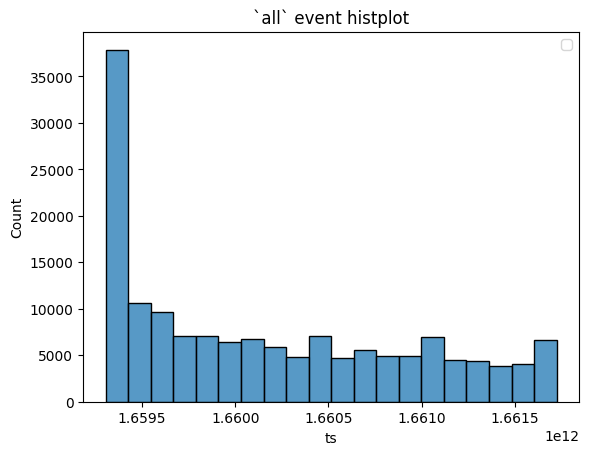

In [51]:
global_quantiles = get_ts_distribution(df_sample_pp, "all", q)

As we can see, there are a lot of data in the start of the period. Possibly it is some big sale. Maybe it is helpful to exclude sale period

In [52]:
TS_MIN = 1659500000000
df_sample_pp_exclude_sale = df_sample_pp[df_sample_pp["ts"] >= TS_MIN]

### Per different event types

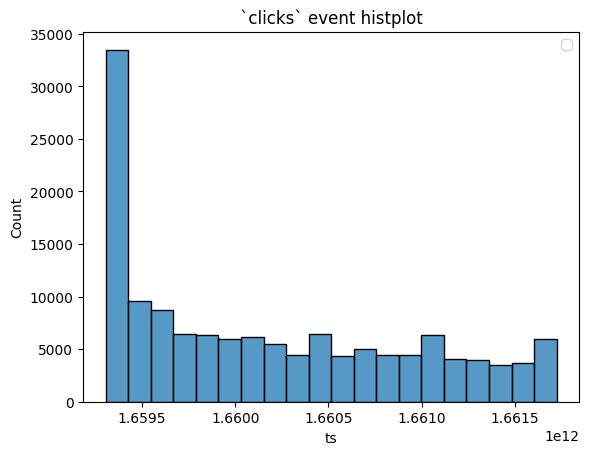

In [53]:
clicks_quantiles = get_ts_distribution(df_sample_pp, "clicks", q)

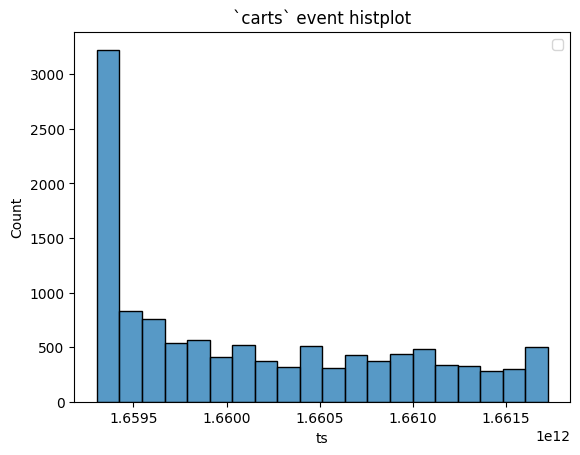

In [54]:
carts_quantiles = get_ts_distribution(df_sample_pp, "carts", q)

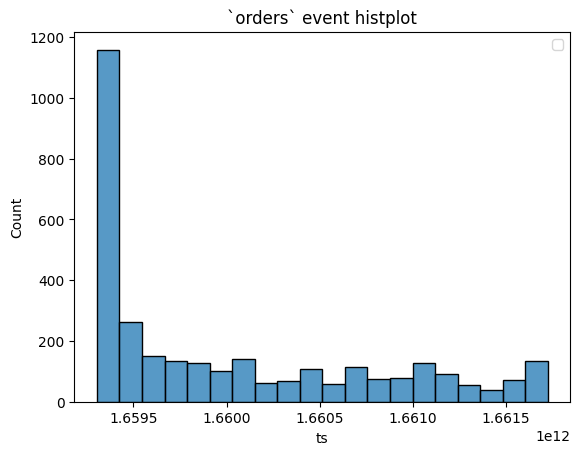

In [56]:
orders_quantiles = get_ts_distribution(df_sample_pp, "orders", q)

## 

In [22]:
from datetime import datetime


df_q_clicks = pd.DataFrame.from_dict(clicks_quantiles, orient="index", columns=["clicks_ts"])
df_q_carts = pd.DataFrame.from_dict(carts_quantiles, orient="index", columns=["carts_ts"])
df_q_orders = pd.DataFrame.from_dict(orders_quantiles, orient="index", columns=["orders_ts"])
df_q_global = pd.DataFrame.from_dict(global_quantiles, orient="index", columns=["global_ts"])


df_q = df_q_clicks.join(df_q_carts).join(df_q_orders).join(df_q_global)

df_q["max_min_deviation_hours"] = (df_q.max(axis=1) - df_q.min(axis=1)) / 1000 / 60 / 60
df_q = df_q.reset_index(drop=False, names=["q"])

df_q.style.background_gradient(subset=["clicks_ts", "carts_ts", "orders_ts", "global_ts"], axis=1)

,q,clicks_ts,carts_ts,orders_ts,global_ts,max_min_deviation_hours
0,0.100000,1659305967930.600098,1659305508746.000000,1659305600861.199951,1659305901785.500000,0.127551
1,0.200000,1659375778014.000000,1659353219921.000000,1659310129586.000000,1659372478177.000000,18.235674
2,0.300000,1659528411632.000000,1659461115713.000000,1659375831566.000000,1659518862121.000000,42.383352
3,0.400000,1659732408665.199951,1659650672146.000000,1659458341360.000000,1659726648560.000000,76.129807
4,0.500000,1659997159265.000000,1659912617946.000000,1659679060542.500000,1659992431196.500000,88.360756
5,0.600000,1660313911680.399902,1660247737279.000000,1659985498990.000000,1660304817956.000000,91.225747
6,0.700000,1660632307440.399902,1660592931625.000000,1660404416983.899902,1660608701141.500000,63.302905
7,0.800000,1660992775985.399902,1660945039097.000000,1660839738011.399902,1660988173605.000000,42.510548
8,0.900000,1661339638234.600098,1661330344503.000000,1661204485952.300049,1661336161083.000000,37.542301


### Global max_min deviation (sampled) in hours:

In [23]:
(df_sample_pp.ts.max() - df_sample_pp.ts.min()) / 1000 / 60 / 60

671.9990241666668

As we can see, the quantiles deviation between actions of different types are not that big. It means that we can choose one single timestamp threshold

## Length of action sequences for different sessions

Mean: 76.923


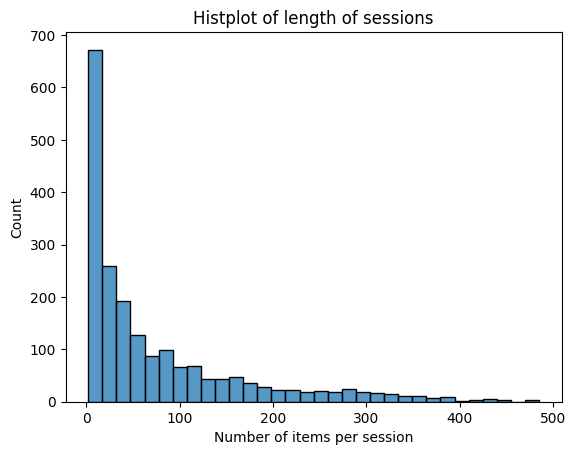

In [30]:
df_gb_all_cnts = df_sample_pp.groupby("session").count()["aid"]
plt.title("Histplot of length of sessions")
sns.histplot(df_gb_all_cnts)

print("Mean:", df_gb_all_cnts.mean())

plt.ylabel("Count")
plt.xlabel("Number of items per session")
plt.show()

We can see that mostly we have not that much actions per session, so it is harder to predict for users that have small amount of actions

# Distibution of events globally

In [31]:
df_sample_pp.groupby("type")["session"].agg(lambda x: len(x) / len(df_sample_pp))

type
carts     0.076837
clicks    0.902675
orders    0.020488
Name: session, dtype: float64

If we exclude possible sale

In [34]:
df_sample_pp_exclude_sale.groupby("type")["session"].agg(lambda x: len(x) / len(df_sample_pp_exclude_sale))

type
carts     0.073728
clicks    0.909562
orders    0.016710
Name: session, dtype: float64

Number of clicks is more that 90% of all data. It is easier to predict them (and harder to predict other targets)

## Length of session

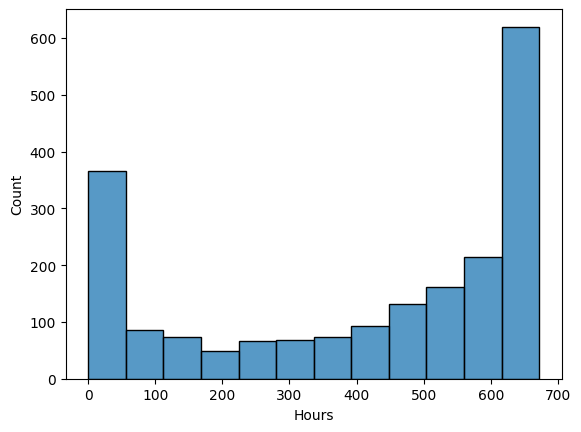

In [36]:
df_session_length = (
    df_sample_pp
    .groupby("session")["ts"]
    .agg(lambda x: (x.max() - x.min()) / 1000 / 60 / 60)
)

sns.histplot(df_session_length)
plt.xlabel("Hours")
plt.show()

We can see that sessions mostly are not short, so it seems that it is ok to divide them to train and test

In this situation session is not just short event, but it something that can actually define separete user

## Interactions with items

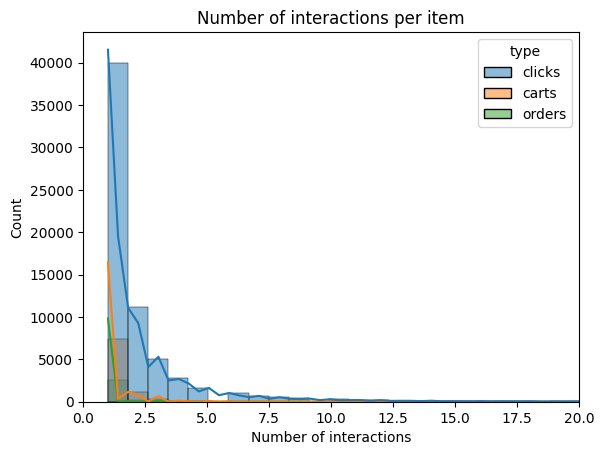

In [47]:
df_items_interactions = df_sample_pp.groupby(["aid", "type"])["session"].count().reset_index()

sns.histplot(df_items_interactions, x="session", hue="type", kde=True, bins=100)
plt.xlim(0, 20)

plt.title("Number of interactions per item")
plt.xlabel("Number of interactions")
plt.show()

In [38]:
df_items_interactions.groupby("type")["session"].mean()

type
carts     1.300440
clicks    2.147410
orders    1.121309
Name: session, dtype: float64

We can see that there is few interactions for different items (mean number is less than 2). So adjacency matrix should be really sparse (relative to items)

It is happening also because of sampled data

It would be interesting to see how parameters relative to real exposures of items (unfortunately we do not have such data)

## Sequential user roadmap

Here we want to check how many orders were previously clicked and then added to cart

In [39]:
def get_orders_fraction_with_correct_user_roadmap(df: pd.DataFrame, keep="last"):
    df_orders = df[df["type"] == "orders"].drop_duplicates(subset=["session", "aid"], keep=keep)
    df_carts = df[df["type"] == "carts"].drop_duplicates(subset=["session", "aid"], keep=keep)
    df_clicks = df[df["type"] == "clicks"].drop_duplicates(subset=["session", "aid"], keep=keep)

    df_orders_carts = (
        df_orders
        .merge(
            df_carts,
            on=["session", "aid"],
            how="inner",
            suffixes=("_orders", "_carts")
        )
    )
    df_orders_carts = df_orders_carts[
        df_orders_carts["ts_orders"] > df_orders_carts["ts_carts"]
    ]
    df_orders_carts.drop_duplicates(subset=["session", "aid"], inplace=True, keep=keep)
    
    df_orders_carts_clicks = (
        df_orders_carts
        .merge(
            df_clicks,
            on=["session", "aid"],
            how="inner",
        )
    )
    df_orders_carts_clicks = df_orders_carts_clicks[
        df_orders_carts_clicks["ts_carts"] > df_orders_carts_clicks["ts"]
    ]
    df_orders_carts_clicks.drop_duplicates(subset=["session", "aid"], inplace=True, keep=keep)
    
    df_orders_clicks = (
        df_orders
        .merge(
            df_clicks,
            on=["session", "aid"],
            how="inner",
            suffixes=("_orders", "_clicks")
        )
    )
    df_orders_clicks = df_orders_clicks[
        df_orders_clicks["ts_orders"] > df_orders_clicks["ts_clicks"]
    ]
    df_orders_clicks.drop_duplicates(subset=["session", "aid"], inplace=True, keep=keep)
    
    df_carts_clicks = (
        df_carts
        .merge(
            df_clicks,
            on=["session", "aid"],
            how="inner",
            suffixes=("_carts", "_clicks")
        )
    )
    df_carts_clicks = df_carts_clicks[
        df_carts_clicks["ts_carts"] > df_carts_clicks["ts_clicks"]
    ]
    df_carts_clicks.drop_duplicates(subset=["session", "aid"], inplace=True, keep=keep)
    
    return (
        {
            "orders": len(df_orders),
            "orders_with_prev_cart": len(df_orders_carts),
            "orders_with_prev_click": len(df_orders_clicks),
            "orders_with_prev_cart_and_prev_click": len(df_orders_carts_clicks),
        },
        {
            "carts": len(df_carts),
            "carts_with_prev_click": len(df_carts_clicks),
        },
        {
            "orders_with_prev_cart / orders": len(df_orders_carts) / len(df_orders),
            "orders_with_prev_click / orders": len(df_orders_clicks) / len(df_orders),
            "orders_with_prev_cart_and_prev_click / orders": len(df_orders_carts_clicks) / len(df_orders),
            "carts_with_prev_clicks / carts": len(df_carts_clicks) / len(df_carts)
        }
    )

In [41]:
orders_dict, carts_dict, fr_dict = get_orders_fraction_with_correct_user_roadmap(df_sample_pp)

In [44]:
pd.DataFrame.from_dict(orders_dict, orient="index", columns=["count"])

,count
orders,2900
orders_with_prev_cart,2251
orders_with_prev_click,1259
orders_with_prev_cart_and_prev_click,756


In [45]:
pd.DataFrame.from_dict(carts_dict, orient="index", columns=["count"])

,count
carts,9709
carts_with_prev_click,3716


In [46]:
pd.DataFrame.from_dict(fr_dict, orient="index", columns=["fraction"])

,fraction
orders_with_prev_cart / orders,0.776207
orders_with_prev_click / orders,0.434138
orders_with_prev_cart_and_prev_click / orders,0.260690
carts_with_prev_clicks / carts,0.382738


As we can see only 28% of orders for this data sample were previously clicked and then added to cart, so consequent prediction is bad decision for such data. The better way is to predict targets independently.

Other statistics are also proves that.

Possible reasons:
- time constraints that leads to truncation of previous clicks and additions to cart in the given data
- business logic that allows users to directly add item to cart or even to order item without any click